In [831]:
import pandas as pd
import numpy as np
import requests
import calendar
import datetime
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import seaborn as sns


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data Import and cleanse

In [832]:
#import imdb, tmdb and cpi tables
movies  = pd.read_csv("IMDb movies.csv")
movies_TMDB = pd.read_csv("movies_tmdb.csv")
ratings = pd.read_csv("IMDb ratings.csv")
cpi = pd.read_csv("CPIAUCNS.csv")

#Join IMDB to TMDB and Rating
movies_all = movies_TMDB.merge(movies, how='inner', left_on='imdb_id', right_on='imdb_title_id')
movies_all = movies_all.merge(ratings, how='inner', left_on='imdb_title_id', right_on='imdb_title_id')

#renaming duplicate columns
movies_all.rename(columns={'budget_y':'budget_imdb'}, inplace=True)
movies_all.rename(columns={'original_title_y':'original_title_imdb'}, inplace=True)
movies_all.rename(columns={'budget_x':'budget_tmdb'}, inplace=True)
movies_all.rename(columns={'original_title_x':'original_title_tmdb'}, inplace=True)

#Establishing Primary Genre
movies_all['genre_abr'] = movies_all['genres'].str.split("}").str[0]
movies_all['primary_genre'] = movies_all["genre_abr"].str.split("'name':").str[1]
movies_all['primary_genre'] = movies_all.primary_genre.str.replace(' ', '')

#Grab month from release date
movies_all['month'] = pd.DatetimeIndex(movies_all['release_date']).month.fillna(0)
movies_all['month'] = movies_all.month.astype(int)
movies_all['Month Name'] = movies_all['month'].apply(lambda x: calendar.month_abbr[x])

#Remove movies not released in US 
movies_all = movies_all[movies_all['country'].str.contains("[USA]").fillna(False)]

/Users/andrewfiegleman/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [877]:
#Get decades based on release date
def decade(df):
    df['release_date']= pd.to_datetime(df['release_date'])
    if (df['release_date'] >datetime.date(1939,12,31) and df['release_date'] < datetime.date(1949,1,1)):
        return '1940s'
    elif (df['release_date'] >datetime.date(1949,12,31) and df['release_date'] < datetime.date(1960,1,1)):
        return '1950s'
    elif (df['release_date'] >datetime.date(1959,12,31) and df['release_date'] <datetime.date(1970,1,1)):
        return '1960s'
    elif (df['release_date'] >datetime.date(1969,12,31) and df['release_date'] <datetime.date(1980,1,1)):
        return '1970s'
    elif (df['release_date'] >datetime.date(1979,12,31) and df['release_date'] <datetime.date(1990,1,1)):
        return '1980s'
    elif (df['release_date'] >datetime.date(1989,12,31) and df['release_date'] <datetime.date(2000,1,1)):
        return '1990s'
    elif (df['release_date'] >datetime.date(1999,12,31) and df['release_date'] <datetime.date(2010,1,1)):
        return '2000s'
    elif (df['release_date'] >datetime.date(2009,12,31) and df['release_date'] <datetime.date(2020,1,1)):
        return '2010s'
    else:
        return "<1940"
    
movies_all['Decade'] = movies_all.apply(decade, axis = 1)

<ipython-input-877-6e7307b719e0>:4: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  if (df['release_date'] >datetime.date(1939,12,31) and df['release_date'] < datetime.date(1949,1,1)):
<ipython-input-877-6e7307b719e0>:6: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  elif (df['release_date'] >datetime.date(1949,12,31) and df['release_date'] < datetime.date(1960,1,1)):
<ipython-input-877-6e7307b719e0>:8: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  elif (df['release_date'] >datetime.date(1959,12,31) and df['release_date'] <datetime.date(1970,1,1)):
<ipython-input-877-6e7307b719e0>:10: FutureWarnin

In [917]:
87000-len(movies_all_release)

42710

## Seasonality X Box office

<ipython-input-924-12525378d99a>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  movies_all_release['usa_gross_income_clean'] = movies_all_release['usa_gross_income'].str.replace('$', '').fillna(0).astype(int)


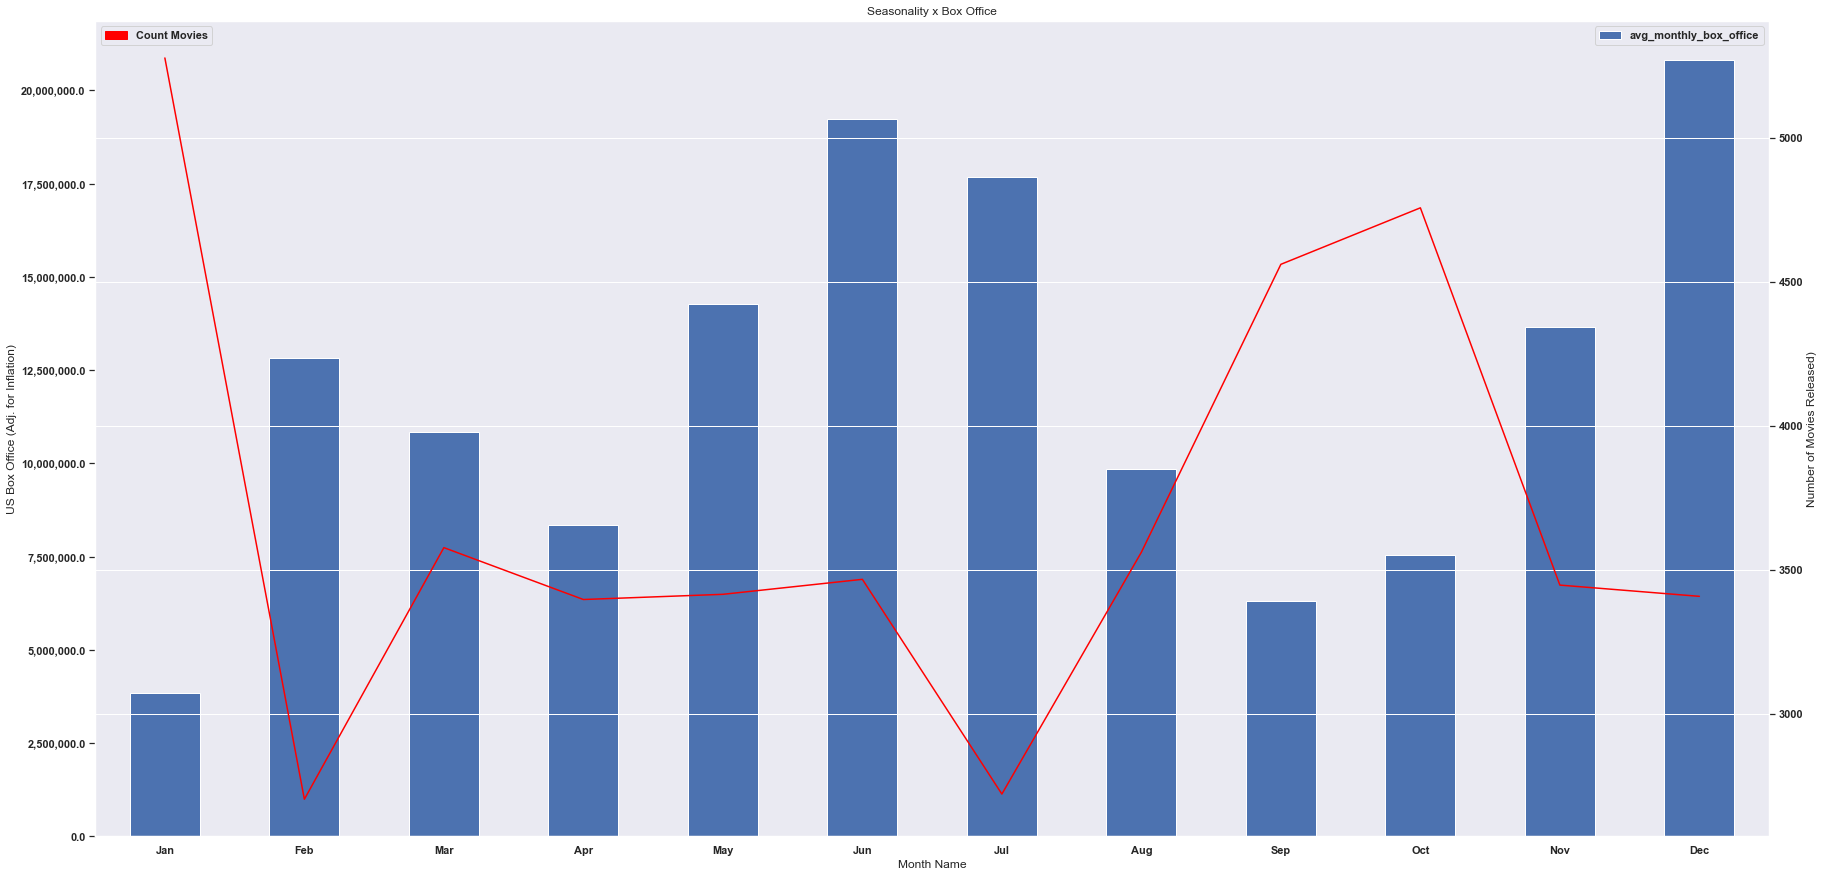

In [924]:
#Clean movies - remove movies with income in other currency and remove '$'
movies_all_release = movies_all[~movies_all['Decade'].str.contains("<1940")]
movies_all_release = movies_all_release[~movies_all_release['usa_gross_income'].str.contains("[a-zA-Z]").fillna(False)]
movies_all_release['usa_gross_income_clean'] = movies_all_release['usa_gross_income'].str.replace('$', '').fillna(0).astype(int)

#grab year from date and make string
cpi['year'] = cpi['DATE'].str[:4]
cpi.year = cpi.year.astype(str)
movies_all_release.year = movies_all_release.year.astype(str)

#join movies and cpi tables
movies_inflated =  pd.merge(movies_all_release, cpi, on="year", how="left")
movies_inflated.to_csv('movies_imdb_tmdb_cpi.csv')

#calculate inflation multiplier
movies_inflated['multiplier'] = 1+(262.231 - movies_inflated['CPIAUCNS'])/movies_inflated['CPIAUCNS']
movies_inflated['usa_gross_income_inflated'] = movies_inflated['usa_gross_income_clean'] * movies_inflated['multiplier']

#Convert date and amount columns to lists, give chart and axes titles and format x-axis
movies_release_date = movies_inflated.groupby(['month','Month Name']).agg({'usa_gross_income_inflated':'mean', 'imdb_id': 'count'}).reset_index().rename(columns={'usa_gross_income_inflated':'avg_monthly_box_office','imdb_id':'count_movies'}).sort_values('month',ascending=True)

ax = movies_release_date.plot.bar(x='Month Name', y='avg_monthly_box_office', rot=0, title='Seasonality x Box Office')
plt.rcParams["figure.figsize"]=(30, 15)
plt.ylabel("US Box Office (Adj. for Inflation)")

ax2 = movies_release_date['count_movies'].plot(secondary_y=True, color = 'red')
plt.ylabel("Number of Movies Released)")
red_patch = mpatches.Patch(color='red', label='Count Movies')
plt.legend(handles=[red_patch], loc='upper left')

ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
plt.rcParams.update({'font.size': 30})


In [879]:
movies_release_date.head(12)

,month,Month Name,avg_monthly_box_office,count_movies
0,1,Jan,3.846502e+06,5276
1,2,Feb,1.282555e+07,2704
2,3,Mar,1.082708e+07,3577
3,4,Apr,8.358415e+06,3397
4,5,May,1.427273e+07,3415
5,6,Jun,1.922349e+07,3467
6,7,Jul,1.768788e+07,2722
7,8,Aug,9.842217e+06,3561
8,9,Sep,6.304424e+06,4560
9,10,Oct,7.544904e+06,4756


In [966]:
(2.082024e+07+1.922349e+07)/movies_release_date.avg_monthly_box_office.sum()

0.27577569306683175

## Seasonality X Reception

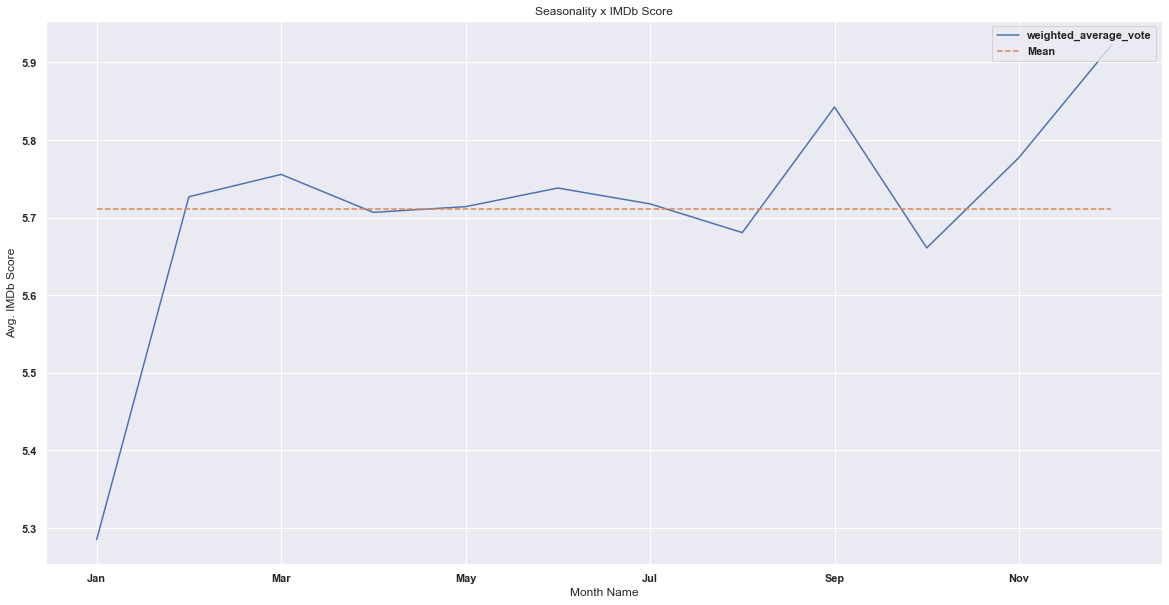

In [965]:
#Filter dates out before 1940, group by month and average vote, remove null months
movies_rating = movies_all[~movies_all['Decade'].str.contains("<1940")]
movies_rating = movies_rating.groupby(['Month Name', 'month']).mean('weighted_average_vote').reset_index()
movies_rating = movies_rating[['Month Name','month','weighted_average_vote']].sort_values('month',ascending=True)
movies_rating = movies_rating[movies_rating['Month Name']!='']

#create and print graph
ax = movies_rating.plot.line(x='Month Name', y='weighted_average_vote', rot=0,title='Seasonality x IMDb Score')
plt.rcParams.update({'font.size': 40})
plt.rcParams["figure.figsize"]=(20, 10)
plt.ylabel("Avg. IMDb Score")

#Create mean graph and print
y_mean = movies_rating.weighted_average_vote.mean()

ax.get_yaxis().get_major_formatter().set_scientific(False)
x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
y_mean = [movies_rating.weighted_average_vote.mean()]*12
mean_line = ax.plot(x,y_mean, label='Mean', linestyle='--')
legend = ax.legend(loc='upper right')


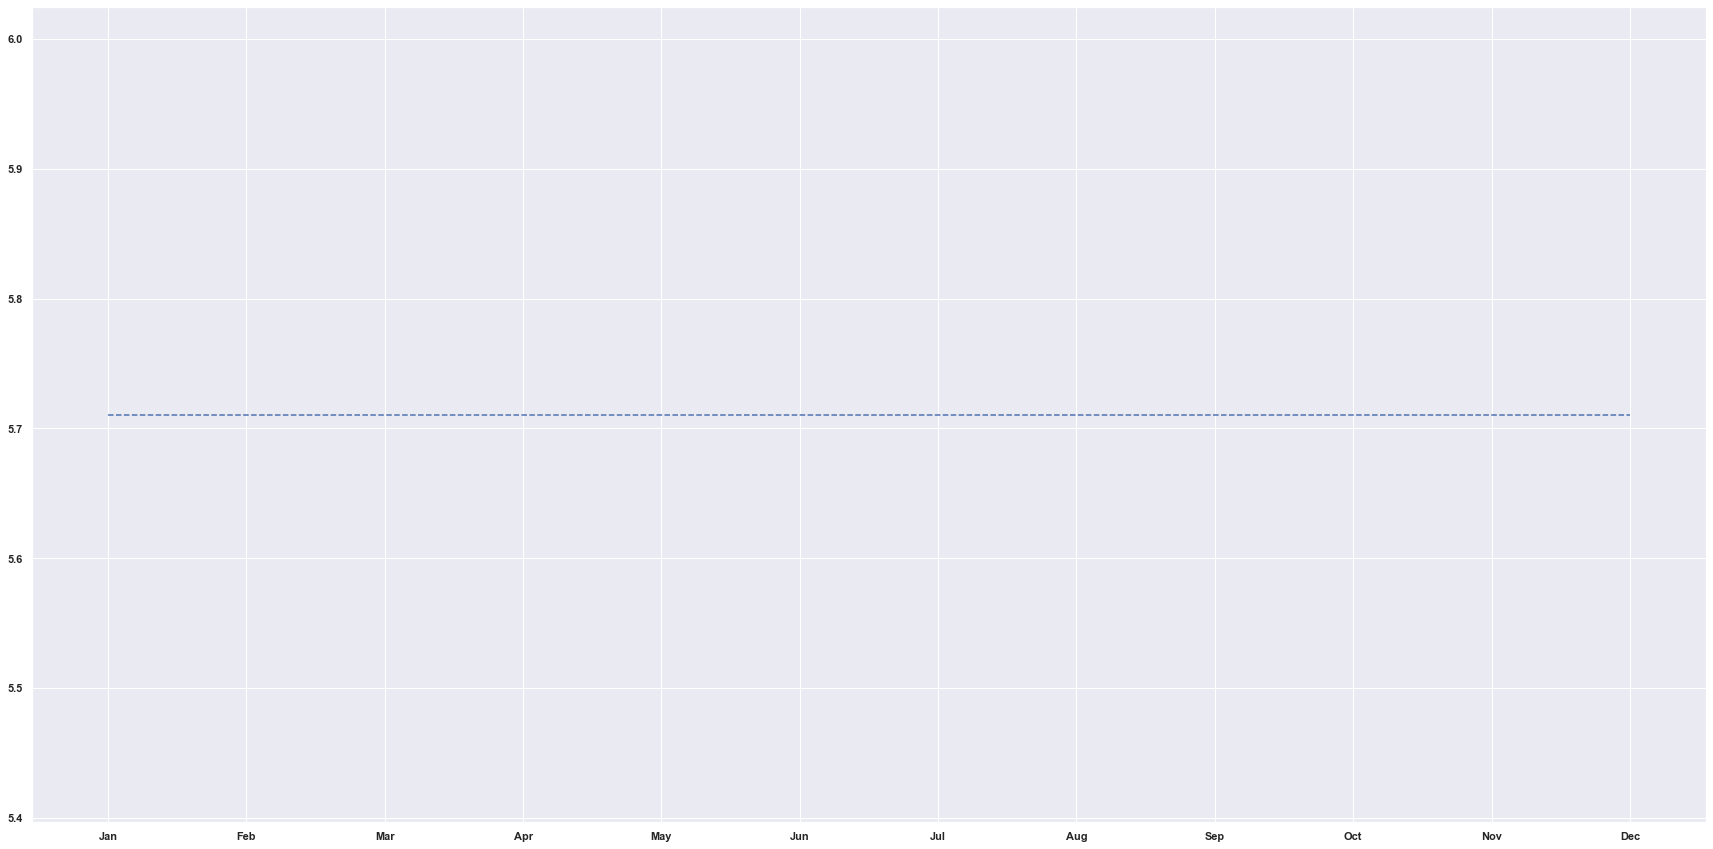

In [906]:
movies_rating

,Month Name,month,weighted_average_vote
4,Jan,1,5.285027
3,Feb,2,5.726960
7,Mar,3,5.755717
0,Apr,4,5.706800
8,May,5,5.714173
6,Jun,6,5.738160
5,Jul,7,5.717744
1,Aug,8,5.680713
11,Sep,9,5.842588
10,Oct,10,5.661018


In [909]:
(5.922001-movies_rating.weighted_average_vote.mean())/movies_rating.weighted_average_vote.mean()

0.03700064503531808

In [907]:
movies_rating

,Month Name,month,weighted_average_vote
4,Jan,1,5.285027
3,Feb,2,5.726960
7,Mar,3,5.755717
0,Apr,4,5.706800
8,May,5,5.714173
6,Jun,6,5.738160
5,Jul,7,5.717744
1,Aug,8,5.680713
11,Sep,9,5.842588
10,Oct,10,5.661018


In [890]:
print((5.7359455314210726 - 5.332442)/5.332442)
print((5.959669-5.7359455314210726)/5.7359455314210726)

0.07566955841640137
0.03900376448022165


### Seasonality and Reception - by genre

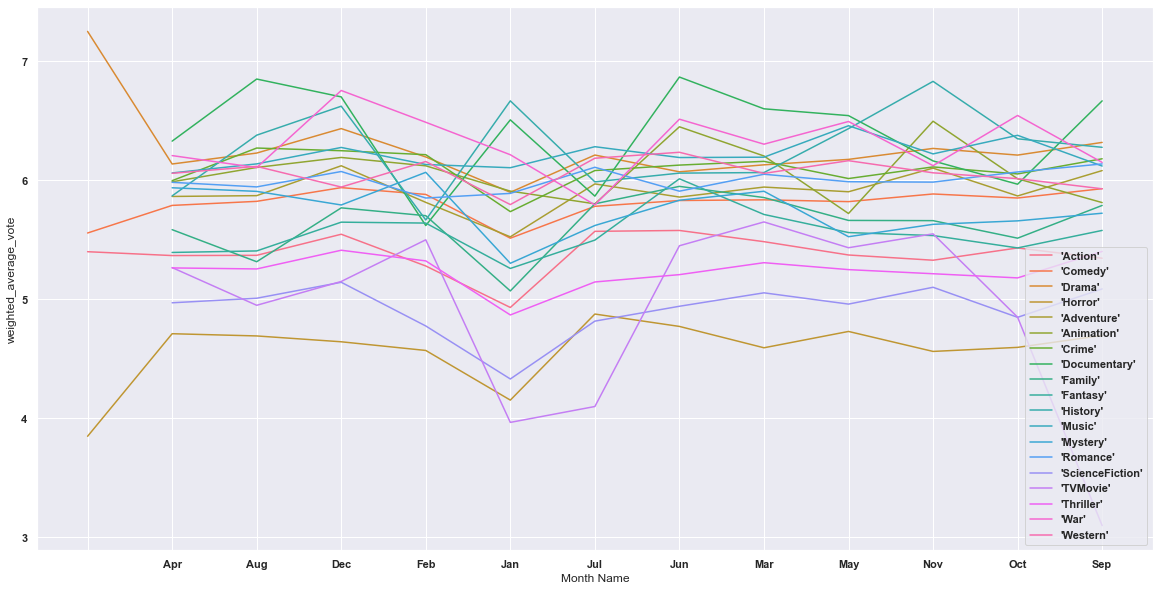

In [862]:
#Create chart for score by month and genre
movie_rating_genre = movies_all.groupby(['Month Name','month', 'primary_genre']).mean('weighted_average_vote').reset_index()
sns.lineplot( x=movie_rating_genre["Month Name"],y=movie_rating_genre["weighted_average_vote"],hue=movie_rating_genre["primary_genre"])
plt.legend(loc='lower right')
sns.set(rc = {'figure.figsize':(25,15)})


# Seasonality x revenue over time

Text(0.5, 1.0, 'Seasonality over Time')

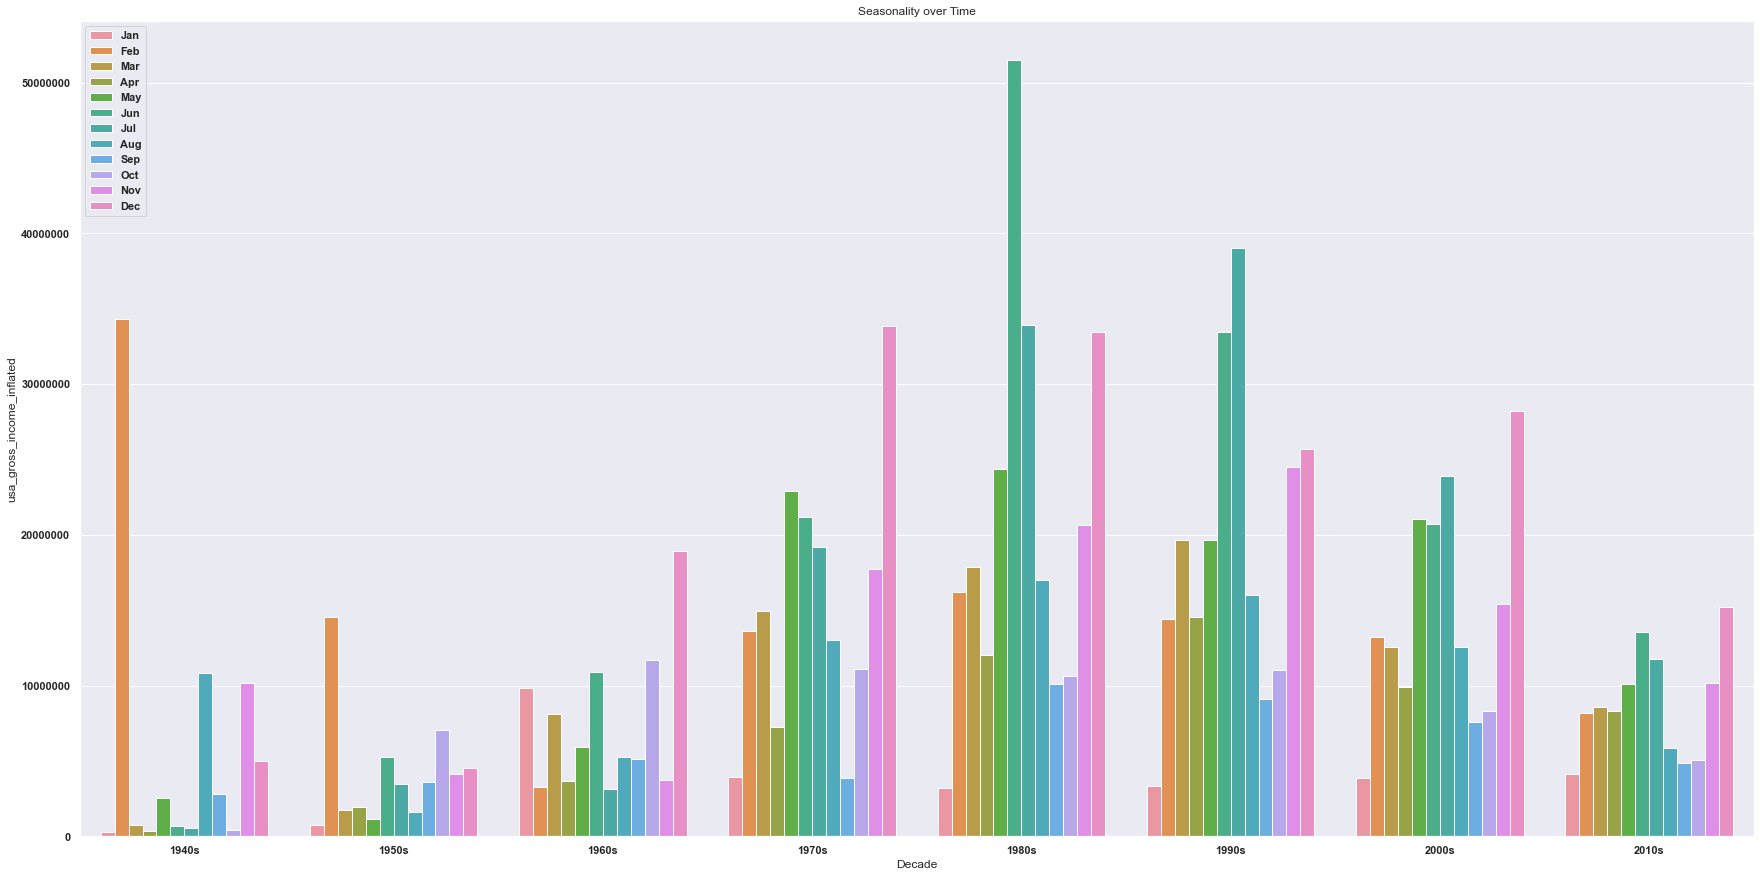

In [901]:
#Remove movies before 1940, group by month and decade and average box office
movie_box_mo_yr = movies_inflated[movies_inflated['Decade']!="<1940"]
movie_box_mo_yr = movie_box_mo_yr.groupby(['Month Name','month', 'Decade']).mean('usa_gross_income_inflated').sort_values(['Decade','month'], ascending=True).reset_index()

#create and print seaborn bar chart
sns.barplot( x=movie_box_mo_yr["Decade"],y=movie_box_mo_yr["usa_gross_income_inflated"],hue=movie_box_mo_yr["Month Name"])
sns.color_palette("Set2")
sns.set(rc = {'figure.figsize':(25,15)})
plt.ticklabel_format(style='plain', axis='y')
plt.legend(loc='upper left')
plt.title("Seasonality over Time")

In [903]:
test

,month,usa_gross_income_inflated
48,1,3.232833e+06
49,2,1.621692e+07
50,3,1.783615e+07
51,4,1.199419e+07
52,5,2.437841e+07
53,6,5.151129e+07
54,7,3.388749e+07
55,8,1.697853e+07
56,9,1.009621e+07
57,10,1.065640e+07


In [904]:
print((2.437841e+07+5.151129e+07+3.388749e+07)/test.usa_gross_income_inflated.sum())
print((1.358246e+07+1.178429e+07+1.013828e+07+1.523029e+07)/test.usa_gross_income_inflated.sum())

0.43757597919554947
0.2022328803351547


In [ ]:
movies.to_csv('movies.csv', index=False)

In [ ]:
tmdb = requests.get("https://api.themoviedb.org/3/movie/"+str(i)+"?api_key=444db3896ca9a69a85444d2131aa1173")
tmdb = tmdb.json()
df = pd.DataFrame.from_dict(tmdb, orient='index')